In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
params = {'tex.usetex': True}

In [2]:
def ps(x, y):
    # produit scalaire entre x et y, qui peuvent être des vecteurs ou des matrices.
    return np.sum(x*y)

In [3]:
class status:
    # classe qui va être utiliser pour stocker les itérées xk, les valeurs f(xk), et les normes des gradients \nabla f(xk)
    # pendant l'éxécution de l'algorithme.
    def __init__(self):
        self.reset()
    def reset(self):
        self.x = []
        self.fx = []
        self.norm_gx = []
    def add(self, x, fx, norm_gx):
        self.x.append(x)
        self.fx.append(fx)
        self.norm_gx.append(norm_gx)

In [4]:
def rebroussement_armijo(f, x, fx, d, gxd, alpha, beta, verbose = False):
    # renvoie le pas de descente via la méthode du rebroussement d'Armijo
    t = 1
    n = 0
    fxtd = f(x + t*d)
    while fxtd >= fx + alpha*t*gxd: # on voit que l'on a une évaluation de f à chaque itération
        t = beta*t
        fxtd = f(x + t*d)
        n += 1

    if verbose:
        # on affiche (si verbose = True) le statut après le calcul du pas de descente par la méthode
        print("Nombre iter armijo : ", n)
        print("f(x) = ", fx)
        print("f(x + t*d) = ", fxtd)
        print("Pas = ", t)
    return t

In [5]:
def descente_gradient_par_rebroussement(x0, f, gradf, f_gradf, alpha, beta, epsilon, niter, verbose = False):
    # Renvoie le dernier itéré et une variable de type status qui contient les xk, f(xk), ||gradf(xk)||
    # Par rapport à la précédente implémentation, on ajoute l'argument f_gradf qui va calculer dans une même fonction
    # la valeur de f(x) et gradf(x). Cela peut-être judicieux d'un point de vue complexité algirithmique car parfois 
    # certaines quantités communes sont calculées à la fois pour f(x) et gradf(x).
    
    x = x0
    fx, gx = f_gradf(x) # on calcule les valeurs de f(x0) et gradf(x0) à l'aide de la fonction f_gradf
    
    verbose_armijo = False # par défaut on n'affiche pas ce qui se passe dans rebroussement_armijo
    
    state = status() # on inialise la variable qui va contenir les xk, f(xk), ||gradf(xk)||
    state.add(x, fx, np.linalg.norm(gx)) # on ajoute à cette variable x0, f(x0), ||gradf(x0)||
    
    n = 0
    while state.norm_gx[-1]/abs(state.fx[-1]) > epsilon and n < niter: # condition d'arrêt    
        if verbose:
            if n%200 == 0:
                verbose_armijo = True # on affiche ce qui se passe dans rebroussement_armijo
                print("Iteration : ", n)
                print("f(x) = ", state.fx[-1])
                print("norm(g(x))/f(x) = ", state.norm_gx[-1]/state.fx[-1])
        
        t = rebroussement_armijo(f, x, fx, -gx, ps(gx, -gx), alpha, beta, verbose_armijo) # calcul du pas de descente par rebroussement
        
        x = x - t*gx # nouvel itéré
        fx, gx = f_gradf(x) # on calcule les nouvelles valeurs de fx et gradf(x) à l'aide de la fonction f_gradf
        
        state.add(x, fx, np.linalg.norm(gx))
        if verbose:
            if n%200 == 0:
                verbose_armijo = False
                print("")
            
        n += 1
    
    return x, state

<h3>Problème d'interpolation</h3>

In [6]:
# paramètre et grille pour les gaussiennes
sigma = 0.02
P = 50
p = np.linspace(0, 1, P)

In [7]:
# génération des données
M = 15
xi = np.zeros(M)
yi = np.zeros(M)
for i in range(M):
    q = np.random.rand()
    if q < 1/3:
        xi[i] = 0.1*(np.random.rand()*2 + 1)
        yi[i] = np.random.rand()*0.5 + 0.5
    else:
        xi[i] = 0.1*(np.random.rand()*3 + 5)
        yi[i] = np.random.rand()*0.5 + 0.5

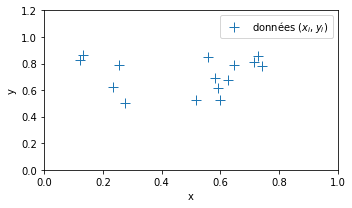

In [8]:
plt.figure(figsize = (5,3))
plt.plot(xi, yi, linestyle = "none", marker = "+", ms = 10, label = r"données $(x_i,y_i)$")
ax = plt.gca()
ax.set_xlim([0,1])
ax.set_ylim([0,1.2])
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
#plt.savefig("data.pdf", dpi = 100)
plt.show()

In [9]:
epsi = 1e-4
def N(t):
    return np.sqrt(t**2 + epsi)
def dN(t):
    return t/N(t)

In [10]:
# Attention ici aux notations utilisées pas cohérentes avec le sujet d'exam. g joue 
def u(x):
    return np.exp(-(x - p)**2/(2*sigma**2))
def f(x, a):
    return np.sum(np.dot(u(x), a))

In [11]:
lbda = 0.1

uxi = np.zeros((M, P))
for i in range(M):
    uxi[i, :] = u(xi[i])

def F(a):
    return 0.5*np.linalg.norm(np.dot(uxi, a) - yi)**2 + lbda*np.sum(N(a))
def gradF(a):
    return np.dot(uxi.transpose(), np.dot(uxi, a) - yi) + lbda*dN(a)
def F_gradF(a):
    # si dans un algo on a besoin d'en même temps évaluer le F et son gradient, il peut être intéressant de les
    # calculer en même temps car certains calculs peuvent être redondants.
    r = np.dot(uxi, a) - yi
    fobj = 0.5*np.linalg.norm(r)**2 + lbda*np.sum(N(a)) # valeur fonction objectif
    gobj = np.dot(uxi.transpose(), r) + lbda*dN(a) # gradient
    return fobj, gobj

In [12]:
# Valider cette case pour vérifier que votre implémentation du gradient de F est correcte
a = np.random.rand(P)
epsilon = 1e-8
e = np.zeros(P)
I = 10
e[I] = 1
print("Cette quantité doit être de l\'ordre de 1e-8 : ", np.linalg.norm(gradF(a)[I] - (F(a + epsilon*e) - F(a))/(epsilon)))

Cette quantité doit être de l'ordre de 1e-8 :  1.5269873665513245e-07


In [13]:
alpha, beta = 1e-4, .2

verbose = True
max_iter = 10000
tol = 1e-6

t_start = time()
a, state = descente_gradient_par_rebroussement(np.zeros(P), F, gradF, F_gradF, alpha, beta, tol, max_iter, verbose)
t_end = time()

print("--- FIN ---")
print("time = ", t_end - t_start)
print("F(x) = ", state.fx[-1])
print("norm(gradF(x))/norm(F(x)) = ", state.norm_gx[-1]/state.fx[-1])
print("niter = ", len(state.x) - 1)

Iteration :  0
f(x) =  4.007950191319649
norm(g(x))/f(x) =  1.4953176268486337
Nombre iter armijo :  1
f(x) =  4.007950191319649
f(x + t*d) =  0.8740814342384802
Pas =  0.2

Iteration :  200
f(x) =  0.5498474587560138
norm(g(x))/f(x) =  0.025261801612050317
Nombre iter armijo :  1
f(x) =  0.5498474587560138
f(x + t*d) =  0.5498398518548773
Pas =  0.2

Iteration :  400
f(x) =  0.5492635190898172
norm(g(x))/f(x) =  0.016445405003978855
Nombre iter armijo :  1
f(x) =  0.5492635190898172
f(x + t*d) =  0.54926273608686
Pas =  0.2

Iteration :  600
f(x) =  0.5491907689253871
norm(g(x))/f(x) =  0.013248484379153281
Nombre iter armijo :  1
f(x) =  0.5491907689253871
f(x + t*d) =  0.5491906407738185
Pas =  0.2

Iteration :  800
f(x) =  0.5491792224001819
norm(g(x))/f(x) =  0.011490598922540396
Nombre iter armijo :  1
f(x) =  0.5491792224001819
f(x + t*d) =  0.5491792016654518
Pas =  0.2

Iteration :  1000
f(x) =  0.5491773627083485
norm(g(x))/f(x) =  0.010388508622493464
Nombre iter armijo :  1

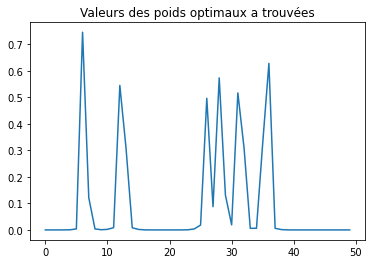

In [14]:
plt.plot(a)
plt.title("Valeurs des poids optimaux a trouvées")
plt.show()

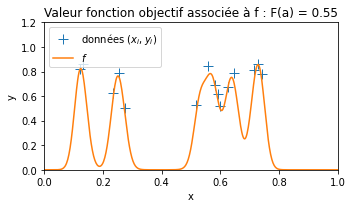

In [15]:
tt = np.linspace(0, 1, 500)
a_ex = state.x[2000] # poids proche du minimum global de F
#a_ex = 0.5*np.random.rand(P) # poids aléatoires. Tester !
ft = [f(t, a_ex) for t in tt]
plt.figure(figsize = (5, 3))
plt.plot(xi, yi, linestyle = "none", marker = "+", ms = 10, label = r"données $(x_i,y_i)$")
plt.plot(tt, ft, label = r"$f$")
ax = plt.gca()
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.2])
plt.xlabel("x")
plt.ylabel("y")
plt.title("Valeur fonction objectif associée à f : F(a) = " + str(np.round(F(a_ex), 2)))
plt.legend()
plt.tight_layout()
#plt.savefig("ex_interp2.pdf", dpi = 100)
plt.show()